In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import cv2
import torch
import random
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import matplotlib.pyplot as plt
import time
import concurrent.futures

In [16]:
# Paths
input_file_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/DFDC/fake'
output_file_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/DFDC/real'
meta_data_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup'
checkpoint_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/checkpoints'
frames_required = 100
valid_csv_path = f'{meta_data_path}/valid_videos.csv'
# valid_csv_path = f'{meta_data_path}/valid_videos_old.csv'

In [3]:
import pandas as pd
import os

# 기존 csv 파일 경로
csv_path = f'{meta_data_path}/valid_videos_old.csv'

# 새로운 기본 경로
base_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/DFDC'

# CSV 읽기 (헤더 있음)
df = pd.read_csv(csv_path)

def replace_path(old_path):
    filename = os.path.basename(old_path)
    if 'real' in old_path.lower():
        return os.path.join(base_path, 'real', filename)
    elif 'fake' in old_path.lower():
        return os.path.join(base_path, 'fake', filename)
    else:
        # real/fake 단어가 없으면 원래 경로 유지하거나 처리
        return old_path

df['video_path'] = df['video_path'].apply(replace_path)

df.to_csv(f'{meta_data_path}/valid_videos.csv', index=False)

print("[INFO] 경로 변경 완료. valid_video_updated.csv 파일로 저장되었습니다.")


NameError: name 'meta_data_path' is not defined

In [5]:
# Transform
im_size = 112
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Frame extractor
def frame_extract(path):
    cap = cv2.VideoCapture(path)
    success, image = cap.read()
    while success:
        yield image
        success, image = cap.read()
    cap.release()

# Validate a single video
def validate_and_count(video_path, transform, required_frames=20):
    try:
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        if total_frames < frames_required:
            return None

        frames = []
        for i, frame in enumerate(frame_extract(video_path)):
            if frame is None: break
            frames.append(transform(frame))
            if len(frames) == required_frames:
                break
        if len(frames) < required_frames:
            return None
        return video_path, total_frames
    except:
        return None

# Step 1 & 2: Validate and filter videos (with CSV caching)
video_files = glob.glob(f'{input_file_path}/*.mp4') + glob.glob(f'{output_file_path}/*.mp4')
print(f"[INFO] Total videos before validation: {len(video_files)}")


[INFO] Total videos before validation: 3085


In [6]:
if os.path.exists(valid_csv_path):
    print("[INFO] Loading validated video list from CSV...")
    valid_df = pd.read_csv(valid_csv_path)
    valid_videos = valid_df['video_path'].tolist()
    frame_counts = valid_df['frame_count'].tolist()
else:
    print("[INFO] Validating videos...")
    valid_videos = []
    frame_counts = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(validate_and_count, v, transform) for v in video_files]
        for f in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Validating videos"):
            result = f.result()
            if result:
                valid_videos.append(result[0])
                frame_counts.append(result[1])
    valid_df = pd.DataFrame({
        'video_path': valid_videos,
        'frame_count': frame_counts
    })
    valid_df.to_csv(valid_csv_path, index=False)
    print(f"[INFO] Saved {len(valid_videos)} valid videos to valid_videos.csv")

print(f"[INFO] Valid videos: {len(valid_videos)} | Avg frames: {np.mean(frame_counts):.2f}")


[INFO] Loading validated video list from CSV...
[INFO] Valid videos: 3064 | Avg frames: 147.63


In [18]:
# Step 3: Dataset and Dataloader
label_df = pd.read_csv(f'{meta_data_path}/metadata.csv', sep='\t', names=["file", "label"])
# label_df = label_df.dropna(subset=["file","label"])

# label_dict = {row["file"]: 0 if str(row["label"]).strip().lower() == "fake" else 1 for _, row in label_df.iterrows()}

print(label_df.columns)
# dropna와 dict 생성
label_df = label_df.dropna(subset=["file", "label"])
label_df["file"] = label_df["file"].apply(lambda x: os.path.splitext(os.path.basename(str(x).strip()))[0])

label_dict = {
    row["file"]: 0 if str(row["label"]).strip().lower() == "fake" else 1
    for _, row in label_df.iterrows()
}

class VideoDataset(Dataset):
    def __init__(self, video_paths, label_dict, sequence_length=10, transform=None):
        self.video_paths = video_paths
        self.label_dict = label_dict
        self.sequence_length = sequence_length
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = []

        for frame in frame_extract(video_path):
            if frame is None: continue
            frames.append(self.transform(frame))
            if len(frames) == self.sequence_length:
                break
        if len(frames) == 0:
            raise RuntimeError(f"No frames extracted from video: {video_path}")

        # frames = torch.stack(frames[:self.sequence_length])
        # label = self.label_dict.get(os.path.basename(video_path), 0)

        file_key = os.path.splitext(os.path.basename(video_path))[0]
        label = self.label_dict.get(file_key, 0)  # fallback은 0

        return frames, label

Index(['file', 'label'], dtype='object')


In [25]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, label_dict, sequence_length=10, transform=None):
        self.video_paths = video_paths
        self.label_dict = label_dict
        self.sequence_length = sequence_length
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = []

        for frame in frame_extract(video_path):
            if frame is None: continue
            frames.append(self.transform(frame))
            if len(frames) == self.sequence_length:
                break
        if len(frames) == 0:
            raise RuntimeError(f"No frames extracted from video: {video_path}")

        # Uncomment this line to stack the list of frame tensors into a single tensor
        frames = torch.stack(frames[:self.sequence_length])
        # label = self.label_dict.get(os.path.basename(video_path), 0)

        file_key = os.path.splitext(os.path.basename(video_path))[0]
        label = self.label_dict.get(file_key, 0)  # fallback은 0

        return frames, label

In [26]:
from collections import Counter
label_counts = Counter(label_dict.values())
print(f"Updated label distribution: {label_counts}")
# 기대 결과: Counter({0: xxx, 1: yyy})  // fake와 real 적절히 섞여 있어야 함

print(f"Train size: {len(train_videos)}")
print(f"Val size: {len(val_videos)}")
print(f"Intersection: {len(set(train_videos) & set(val_videos))}")



Updated label distribution: Counter({1: 2513, 0: 2362})
Train size: 2144
Val size: 920
Intersection: 0


In [27]:
# CSV 파일을 제대로 읽고 있는지 확인
# label_df = pd.read_csv(f'{meta_data_path}/metadata.csv')
# print(label_df.head())
# print(label_df.columns)

In [35]:
# Train/Val Split
random.shuffle(valid_videos)
train_split = int(0.7 * len(valid_videos))
train_videos = valid_videos[:train_split]
val_videos = valid_videos[train_split:]

train_data = VideoDataset(train_videos, label_dict, transform=transform)
val_data = VideoDataset(val_videos, label_dict, transform=transform)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=6)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False, num_workers=6)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [36]:
# Step 4: Model
class Model(nn.Module):
    def __init__(self, num_classes=2, latent_dim=1280, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        base = models.efficientnet_b0(pretrained=True)
        self.features = base.features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        x = self.features(x)
        x = self.avgpool(x).view(B, T, -1)
        x, _ = self.lstm(x)
        out = self.fc(self.dropout(x.mean(dim=1)))
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [37]:
# Step 5: Train & Evaluate
def calculate_accuracy(outputs, targets):
    _, preds = outputs.max(1)
    return (preds == targets).float().mean().item() * 100

def train_epoch(epoch, model, loader, criterion, optimizer):
    model.train()
    total_loss, total_acc = 0, 0
    start_time = time.time()

    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        acc = calculate_accuracy(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc

        if (i + 1) % 10 == 0:
            elapsed = time.time() - start_time
            eta = elapsed / (i + 1) * (len(loader) - i - 1)
            print(f"\r[Train] Epoch {epoch} | Batch {i+1}/{len(loader)} | Loss: {loss.item():.4f} | Acc: {acc:.2f}% | ETA: {eta:.1f}s", end="")

    print()
    return total_loss / len(loader), total_acc / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            acc = calculate_accuracy(outputs, y)

            total_loss += loss.item()
            total_acc += acc

            preds = outputs.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.cpu().numpy())

    return total_loss / len(loader), total_acc / len(loader), y_true, y_pred


In [38]:
# Step 6: Training Loop
train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 10
for epoch in range(1, epochs + 1):
    print(f"\n[INFO] Starting Epoch {epoch}/{epochs}")
    train_loss, train_acc = train_epoch(epoch, model, train_loader, criterion, optimizer)
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[INFO] Epoch {epoch} Completed | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")






[INFO] Starting Epoch 1/10


KeyboardInterrupt: 

In [39]:
def load_checkpoint(path, model, optimizer):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_acc = checkpoint['val_acc']
        print(f"[INFO] Loaded checkpoint from epoch {start_epoch} with best val acc: {best_val_acc:.2f}%")
        return start_epoch, best_val_acc
    else:
        print("[INFO] No checkpoint found. Starting from scratch.")
        return 0, 0.0


In [40]:
# 학습 설정
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epochs = 7
checkpoint_path = 'best_checkpoint.pth'

# 체크포인트 로딩
start_epoch, best_val_acc = load_checkpoint(checkpoint_path, model, optimizer)

# 이어서 학습
for epoch in range(start_epoch + 1, epochs + 1):
    print(f"\n[INFO] Starting Epoch {epoch}/{epochs}")
    train_loss, train_acc = train_epoch(epoch, model, train_loader, criterion, optimizer)
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[INFO] Epoch {epoch} Completed | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # 최고 성능 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': best_val_acc
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"[INFO] Saved checkpoint at Epoch {epoch} with Val Acc: {val_acc:.2f}%")

print("[INFO] Training Complete")


[INFO] No checkpoint found. Starting from scratch.

[INFO] Starting Epoch 1/7
[Train] Epoch 1 | Batch 530/536 | Loss: 0.5608 | Acc: 50.00% | ETA: 23.5s
[INFO] Epoch 1 Completed | Train Acc: 67.02% | Val Acc: 72.83%
[INFO] Saved checkpoint at Epoch 1 with Val Acc: 72.83%

[INFO] Starting Epoch 2/7
[Train] Epoch 2 | Batch 530/536 | Loss: 0.7446 | Acc: 50.00% | ETA: 23.6s
[INFO] Epoch 2 Completed | Train Acc: 76.17% | Val Acc: 78.70%
[INFO] Saved checkpoint at Epoch 2 with Val Acc: 78.70%

[INFO] Starting Epoch 3/7
[Train] Epoch 3 | Batch 530/536 | Loss: 0.1196 | Acc: 100.00% | ETA: 23.3s
[INFO] Epoch 3 Completed | Train Acc: 81.53% | Val Acc: 83.26%
[INFO] Saved checkpoint at Epoch 3 with Val Acc: 83.26%

[INFO] Starting Epoch 4/7
[Train] Epoch 4 | Batch 530/536 | Loss: 0.5375 | Acc: 50.00% | ETA: 23.6s
[INFO] Epoch 4 Completed | Train Acc: 85.21% | Val Acc: 79.46%

[INFO] Starting Epoch 5/7
[Train] Epoch 5 | Batch 530/536 | Loss: 0.0261 | Acc: 100.00% | ETA: 23.5s
[INFO] Epoch 5 Complet

In [41]:
# 전체 모델 저장
torch.save(model, 'final_model.pth')


[CONFUSION MATRIX]:
 [[350  89]
 [ 57 424]]

[CLASSIFICATION REPORT]:
              precision    recall  f1-score   support

        Fake       0.86      0.80      0.83       439
        Real       0.83      0.88      0.85       481

    accuracy                           0.84       920
   macro avg       0.84      0.84      0.84       920
weighted avg       0.84      0.84      0.84       920



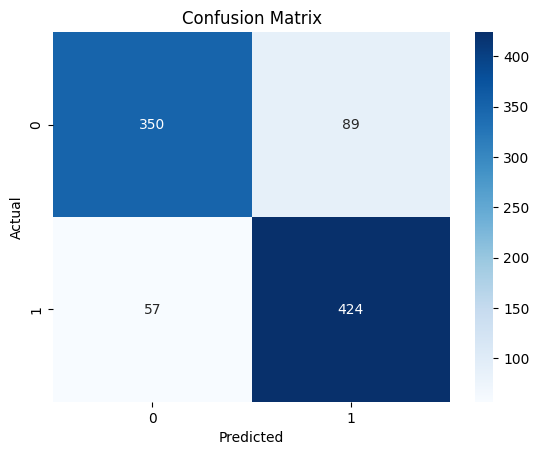

In [42]:
# Step 7: Confusion Matrix
def print_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print("\n[CONFUSION MATRIX]:\n", cm)
    print("\n[CLASSIFICATION REPORT]:")
    print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))
    sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

print_confusion(y_true, y_pred)